In [7]:
# 라이브러리 호출
%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
from pathlib import Path
import cv2

# 유틸리티 함수 정의
def create_count_df(df, field, index):
    count = df.groupby(field)[index].count().sort_values(ascending=False)
    count_df = count.to_frame().reset_index()
    count_df.columns = [field, field + '_count']
    return count_df

def plot_count_df(df, field, random_sample, color, rotation, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10,6))
    if random_sample:
        df = df.sample(n=50, random_state=1)
    bars = ax.bar(df[field], df[field + '_count'], color=color, align='center', alpha=0.5)
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()*(1/2), b.get_height()+0.1,
                df.iloc[i][field + '_count'], ha='center', fontsize=13)
    ax.set_xticklabels(df[field], rotation=rotation, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

In [8]:
# json 파일 읽기
def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann

path_lists = glob.glob(f"../data/*_receipt/ufo/*train.json")

# 각 json 파일을 읽어서 하나로 합친다
data = {}
data['images'] = {}
for path in path_lists:
    json_data = read_json(path)
    images = list(json_data['images'].items())[:100]  # 각 파일에서 100개씩만
    data['images'].update(dict(images))

print(f"Total number of images: {len(data['images'])}")

Total number of images: 400


In [22]:
# 데이터 구조화
df = {
    'image': [],              
    'word_counts': [],        
    'image_width': [],        
    'image_height': [],       
    'image_tags': [],         
}

# 전체 단어 정보를 저장할 리스트들
words_info = {
    'index': [],
    'text': [],
    'language': [],
    'orientation': [],
    'word_tags': [],
    'bbox_width': [],
    'bbox_height': [],
    'bbox_area': [],
    'bbox_size': [],        # bbox_size 추가
    'aspect_ratio': []
}

# 데이터 추출
word_idx = 0  # 단어 인덱스 추적용
for img_id, img_info in data['images'].items():
    # 이미지 정보 저장
    df['image'].append(img_id)
    df['image_width'].append(img_info['img_w'])
    df['image_height'].append(img_info['img_h'])
    df['image_tags'].append(img_info.get('tags', ['None']))
    
    valid_words = 0
    for word_id, word in img_info['words'].items():
        if not word.get('illegibility', False):
            valid_words += 1
            
            # 단어 정보 저장
            words_info['index'].append(word_idx)
            words_info['text'].append(word.get('transcription', ''))
            words_info['language'].append(word.get('language', 'None'))
            words_info['orientation'].append(word.get('orientation', 'Horizontal'))
            words_info['word_tags'].append(word.get('tags', ['None']))
            
            # bbox 계산
            points = np.array(word.get('points', []))
            if len(points) > 0:
                x_coords = points[:, 0]
                y_coords = points[:, 1]
                width = max(x_coords) - min(x_coords)
                height = max(y_coords) - min(y_coords)
                bbox_size = width * height  # bbox_size 계산
                words_info['bbox_width'].append(width)
                words_info['bbox_height'].append(height)
                words_info['bbox_area'].append(width * height)
                words_info['bbox_size'].append(bbox_size)  # bbox_size 추가
                words_info['aspect_ratio'].append(width / height if height != 0 else 0)
            else:
                words_info['bbox_width'].append(0)
                words_info['bbox_height'].append(0)
                words_info['bbox_area'].append(0)
                words_info['bbox_size'].append(0)  # bbox_size 추가
                words_info['aspect_ratio'].append(0)
            
            word_idx += 1
    
    df['word_counts'].append(valid_words)

# DataFrame 생성
image_df = pd.DataFrame(df)
word_df = pd.DataFrame(words_info)

# None 값 처리
image_df['image_tags'] = image_df['image_tags'].apply(lambda x: ['None'] if x is None else x)

In [23]:
image_df.head()

,image,word_counts,image_width,image_height,image_tags
0,extractor.zh.in_house.appen_000692_page0001.jpg,34,1280,1707,[]
1,extractor.zh.in_house.appen_000835_page0001.jpg,49,1280,1707,[]
2,extractor.zh.in_house.appen_000849_page0001.jpg,37,678,1240,[]
3,extractor.zh.in_house.appen_000389_page0001.jpg,52,3024,4032,[]
4,extractor.zh.in_house.appen_000333_page0001.jpg,197,1418,2127,[]


In [24]:
word_df.head()

,index,text,language,orientation,word_tags,bbox_width,bbox_height,bbox_area,bbox_size,aspect_ratio
0,0,广安宝蔬菜超市,None,Horizontal,[None],317.908775,65.554600,20840.382582,20840.382582,4.849527
1,1,,None,Horizontal,[None],609.174412,69.590918,42393.006536,42393.006536,8.753648
2,2,机号：,None,Horizontal,[None],115.005635,58.275781,6702.043199,6702.043199,1.973472
3,3,B372-0386,None,Horizontal,[None],228.392495,53.177467,12145.334366,12145.334366,4.294911
4,4,收银员：06,None,Horizontal,[None],220.161646,66.096548,14551.924803,14551.924803,3.330910


<Figure size 1500x500 with 0 Axes>

<Axes: >

<Axes: xlabel='image_width', ylabel='Count'>

Text(0.5, 1.0, 'Image Width Distribution')

<Axes: >

<Axes: xlabel='image_height', ylabel='Count'>

Text(0.5, 1.0, 'Image Height Distribution')

<Axes: >

<Axes: xlabel='word_counts', ylabel='Count'>

Text(0.5, 1.0, 'Words per Image Distribution')

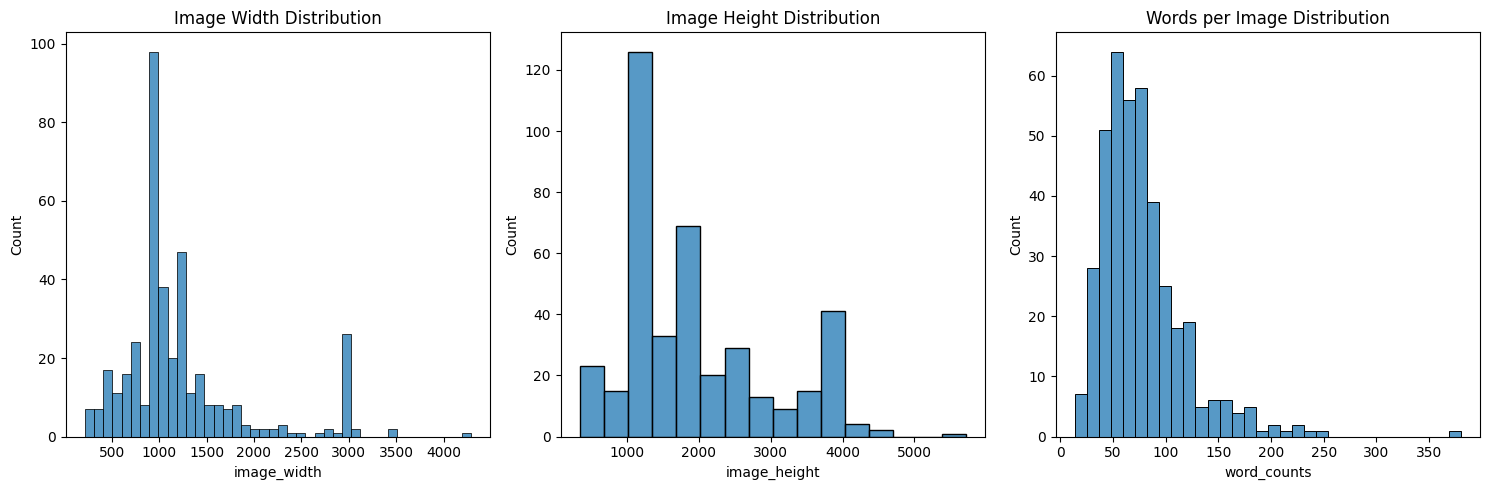

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.histplot(data=image_df, x='image_width')
plt.title('Image Width Distribution')
plt.subplot(132)
sns.histplot(data=image_df, x='image_height')
plt.title('Image Height Distribution')
plt.subplot(133)
sns.histplot(data=image_df, x='word_counts')
plt.title('Words per Image Distribution')
plt.tight_layout()
plt.show()

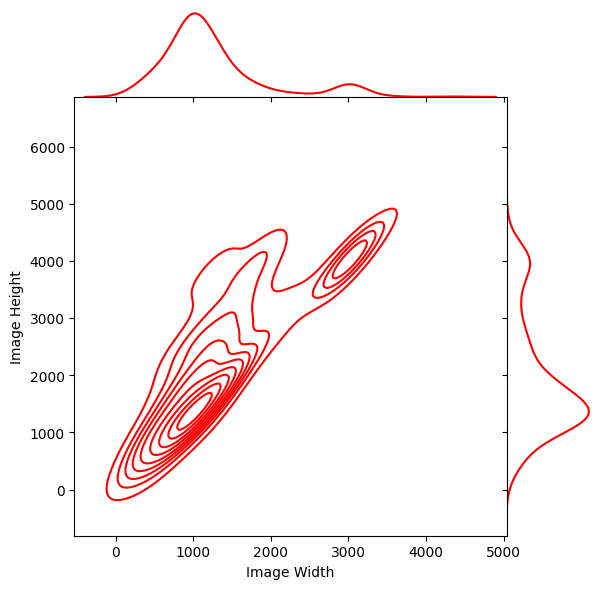

In [14]:
g = sns.jointplot(x = "image_width", y = "image_height", data=image_df, kind="kde", space=0, color="r")
g.set_axis_labels("Image Width", "Image Height")

<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='aspect_ratio', ylabel='Count'>

Text(0.5, 1.0, 'Word Bounding Box Aspect Ratio Distribution')

Text(0.5, 0, 'Aspect Ratio (width/height)')

Text(0, 0.5, 'Count')

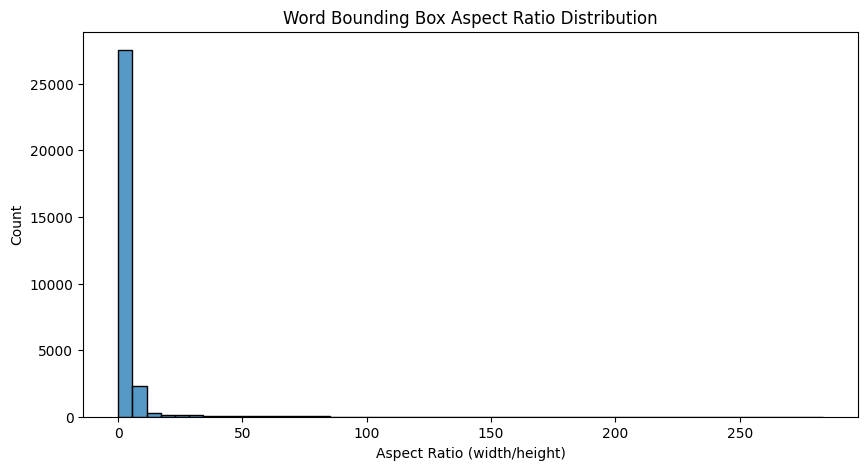

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(data=word_df, x='aspect_ratio', bins=50)
plt.title('Word Bounding Box Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (width/height)')
plt.ylabel('Count')
plt.show()

/tmp/ipykernel_182345/3209660399.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[field], bins=bins, color=color, ax=ax)


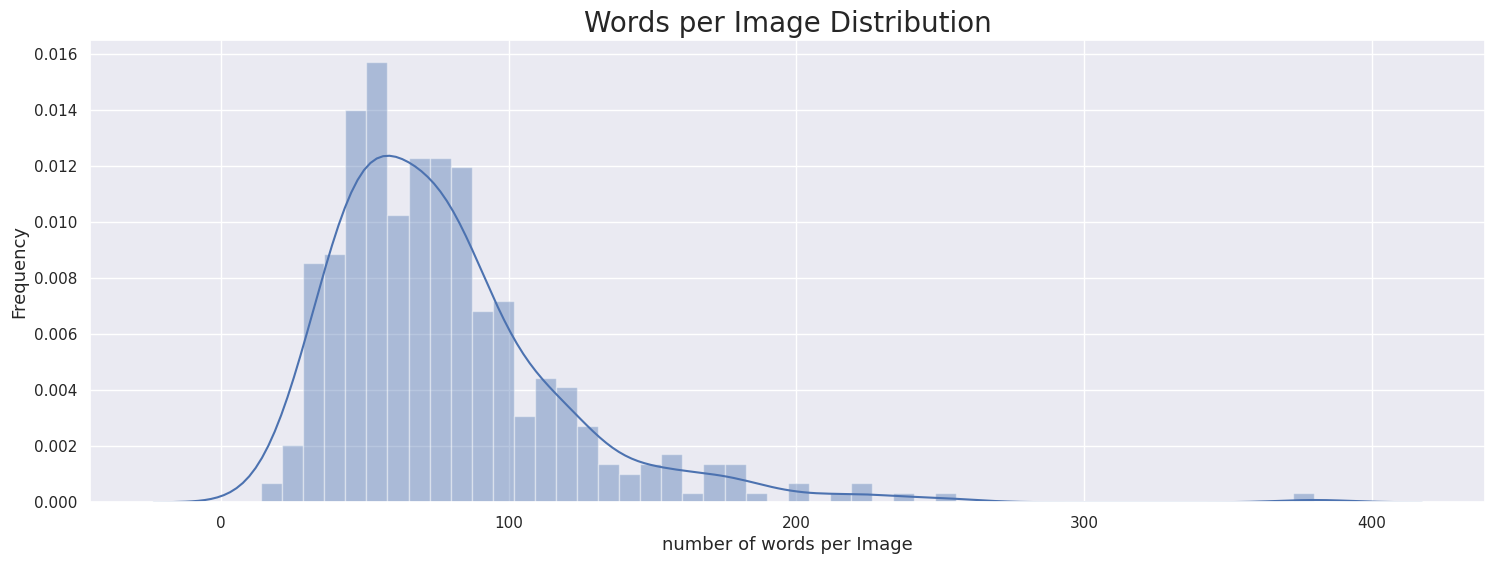

In [19]:
def plot_dist(df, field, bins, color, xlabel, ylabel, title):
    sns.set(color_codes=True)
    fig, ax = plt.subplots(figsize=(18,6))
    sns.distplot(df[field], bins=bins, color=color, ax=ax)

    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

plot_dist(df=image_df, field='word_counts', bins=50, color='b', xlabel='number of words per Image', \
          ylabel='Frequency', title='Words per Image Distribution')

BBox Size Statistics:
count     31162.000000
mean       7678.098783
std       17335.933230
min           6.821132
25%         976.376614
50%        2538.169890
75%        7151.262107
max      511254.223384
Name: bbox_size, dtype: float64


<Figure size 1500x500 with 0 Axes>

<Axes: >

<Axes: xlabel='bbox_size', ylabel='Count'>

Text(0.5, 1.0, 'BBox Size Distribution')

Text(0.5, 0, 'BBox Size')

Text(0, 0.5, 'Count')

<Axes: >

<Axes: ylabel='bbox_size'>

Text(0.5, 1.0, 'BBox Size Box Plot')

Text(0, 0.5, 'BBox Size')

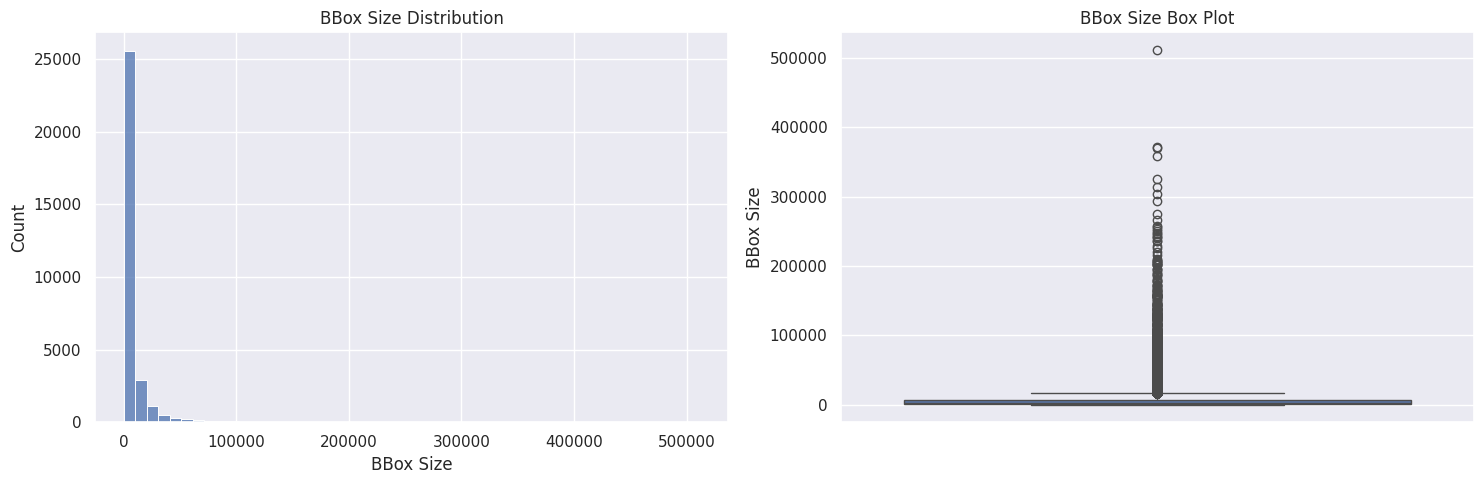

<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='bbox_size', ylabel='Count'>

Text(0.5, 1.0, 'BBox Size Distribution (Log Scale)')

Text(0.5, 0, 'BBox Size (log scale)')

Text(0, 0.5, 'Count')

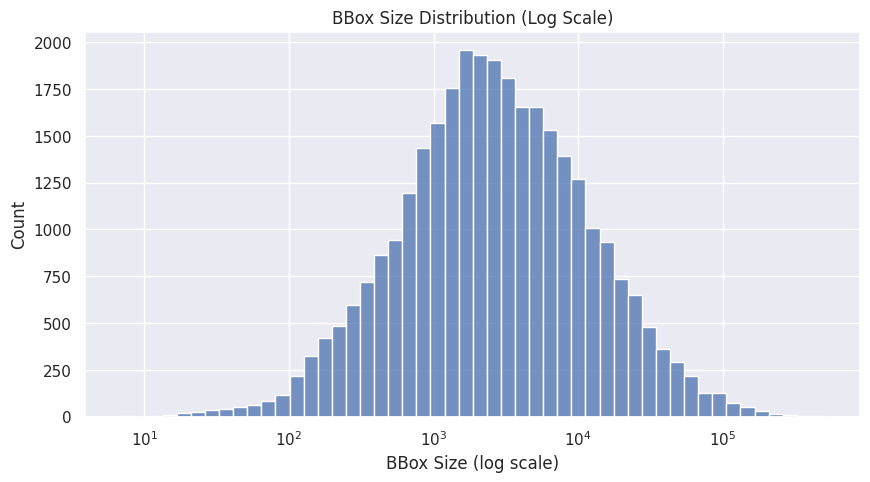

In [25]:
print("BBox Size Statistics:")
print(word_df['bbox_size'].describe())

plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(data=word_df, x='bbox_size', bins=50)
plt.title('BBox Size Distribution')
plt.xlabel('BBox Size')
plt.ylabel('Count')

plt.subplot(122)
sns.boxplot(data=word_df, y='bbox_size')
plt.title('BBox Size Box Plot')
plt.ylabel('BBox Size')

plt.tight_layout()
plt.show()

# Log scale로도 확인 (bbox_size가 매우 큰 차이를 보일 수 있으므로)
plt.figure(figsize=(10, 5))
sns.histplot(data=word_df, x='bbox_size', bins=50, log_scale=True)
plt.title('BBox Size Distribution (Log Scale)')
plt.xlabel('BBox Size (log scale)')
plt.ylabel('Count')
plt.show()

/tmp/ipykernel_182345/3209660399.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[field], bins=bins, color=color, ax=ax)


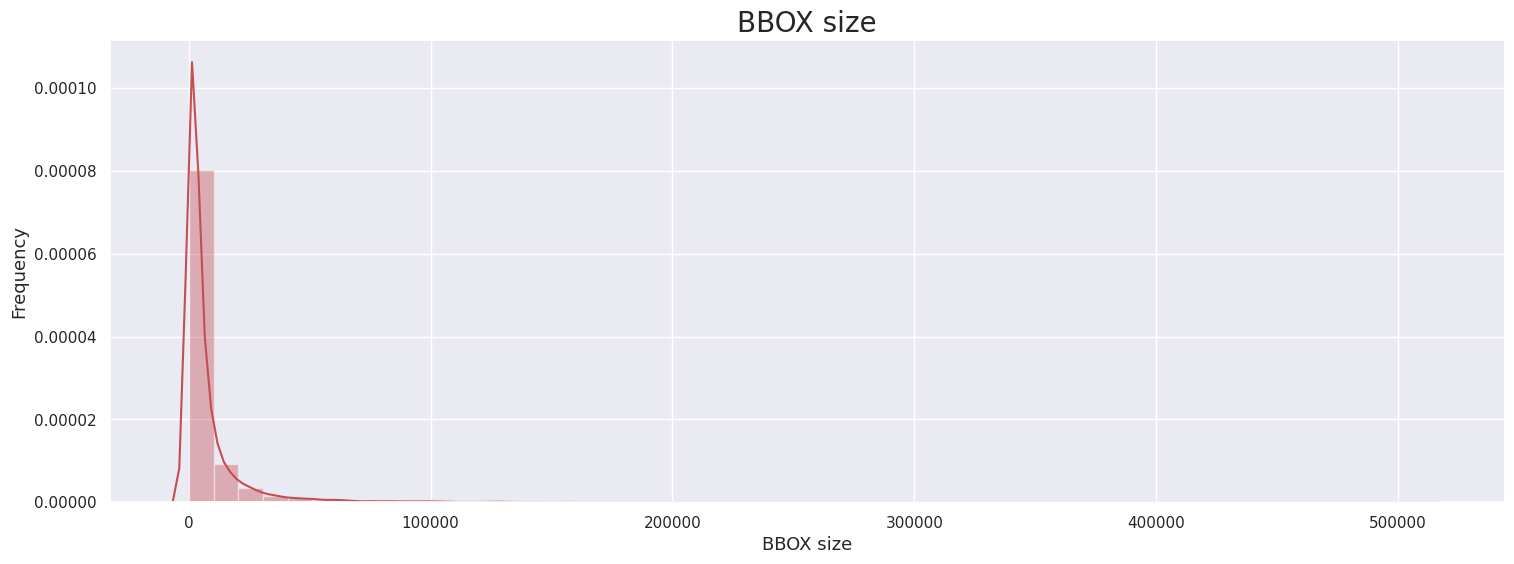

In [26]:
plot_dist(df=word_df, field='bbox_size', bins=50, color='r', xlabel='BBOX size', \
          ylabel='Frequency', title='BBOX size')

Image ID: extractor.zh.in_house.appen_000104_page0001.jpg
Image Path: ../data/chinese_receipt/img/train/extractor.zh.in_house.appen_000104_page0001.jpg
Image Size: 2641 x 3521
Image Tags: []
Total Words: 109


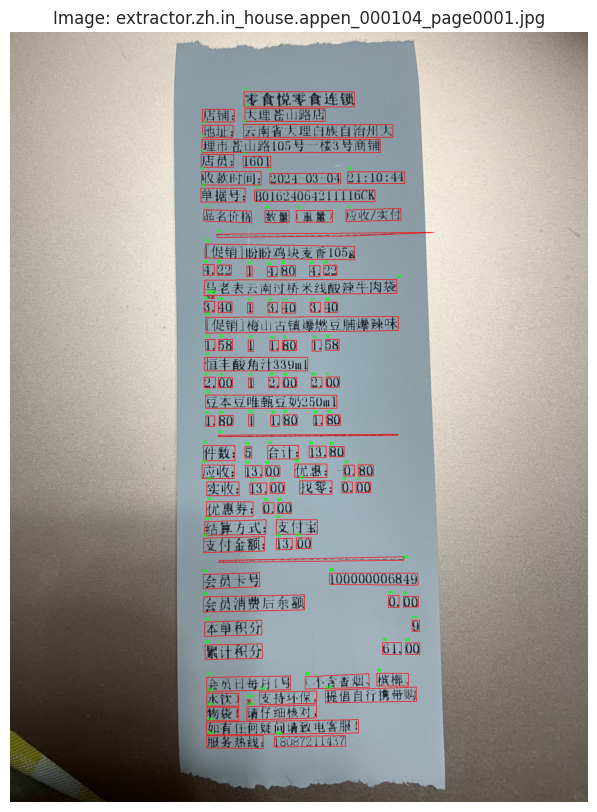


Word Information:
--------------------------------------------------
Word 0:
  Text: 零食悦零食连锁
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 1:
  Text: 店铺：
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 2:
  Text: 大理苍山路店
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 3:
  Text: 地址：
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 4:
  Text: 云南省大理白族自治州大
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 5:
  Text: 理市苍山路105号一楼3号商铺
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 6:
  Text: 店员：
  Language: None
  Orientation: Horizontal
  Tags: ['None']
-------------------------------------

In [33]:
# 이미지와 json 경로 설정
def get_image_paths():
    # json 파일 경로
    json_paths = glob.glob(f"../data/*_receipt/ufo/*train.json")
    
    # 이미지 경로 매핑 딕셔너리 생성
    image_paths = {}
    for json_path in json_paths:
        # json 경로에서 이미지 폴더 경로 추출
        # ../data/기업_receipt/ufo/train.json -> ../data/기업_receipt/img/train
        img_dir = str(Path(json_path).parent.parent / 'img/train')
        
        # 해당 폴더의 json 읽기
        json_data = read_json(json_path)
        
        # 각 이미지 ID에 대한 전체 경로 매핑
        for img_id in json_data['images'].keys():
            image_paths[img_id] = str(Path(img_dir) / img_id)
    
    return image_paths

# 이미지 경로 매핑 생성
image_paths = get_image_paths()

# 시각화 함수 수정
def visualize_random_image_with_info(data, image_paths):
    """
    랜덤한 이미지 하나를 선택하여 바운딩 박스와 텍스트 정보를 시각화
    """
    # 랜덤한 이미지 선택
    random_img_id = np.random.choice(list(data['images'].keys()))
    img_info = data['images'][random_img_id]
    
    # 이미지 로드
    img_path = image_paths[random_img_id]
    img = cv2.imread(img_path)
    if img is None:
        print(f"Cannot load image: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 이미지 정보 출력
    print("="*50)
    print(f"Image ID: {random_img_id}")
    print(f"Image Path: {img_path}")
    print(f"Image Size: {img_info['img_w']} x {img_info['img_h']}")
    print(f"Image Tags: {img_info.get('tags', ['None'])}")
    print(f"Total Words: {len(img_info['words'])}")
    print("="*50)
    
    # 단어 정보를 저장할 리스트
    word_info_list = []
    
    # 이미지에 바운딩 박스 그리기
    for word_id, word in img_info['words'].items():
        if not word.get('illegibility', False):
            points = np.array(word.get('points', []))
            if len(points) > 0:
                # 박스 그리기
                cv2.polylines(img, [points.astype(np.int32)], True, (255, 0, 0), 2)
                
                # 텍스트 번호 표시 (박스 왼쪽 상단)
                x, y = points[0]
                cv2.putText(img, str(len(word_info_list)), (int(x), int(y)-10), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                
                # 단어 정보 저장
                word_info = {
                    'index': len(word_info_list),
                    'text': word.get('transcription', ''),
                    'language': word.get('language', 'None'),
                    'orientation': word.get('orientation', 'Horizontal'),
                    'tags': word.get('tags', ['None'])
                }
                word_info_list.append(word_info)
    
    # 이미지 표시
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.title(f'Image: {random_img_id}')
    plt.axis('off')
    plt.show()
    
    # 단어 정보 출력
    print("\nWord Information:")
    print("-"*50)
    for word_info in word_info_list:
        print(f"Word {word_info['index']}:")
        print(f"  Text: {word_info['text']}")
        print(f"  Language: {word_info['language']}")
        print(f"  Orientation: {word_info['orientation']}")
        print(f"  Tags: {word_info['tags']}")
        print("-"*50)

# 실행
visualize_random_image_with_info(data, image_paths)

Loading image from: ../data/chinese_receipt/img/train/extractor.zh.in_house.appen_000700_page0001.jpg
Image ID: extractor.zh.in_house.appen_000700_page0001.jpg
Image Path: ../data/chinese_receipt/img/train/extractor.zh.in_house.appen_000700_page0001.jpg
Image Size: 3024 x 4032
Image Tags: []
Total Words: 76


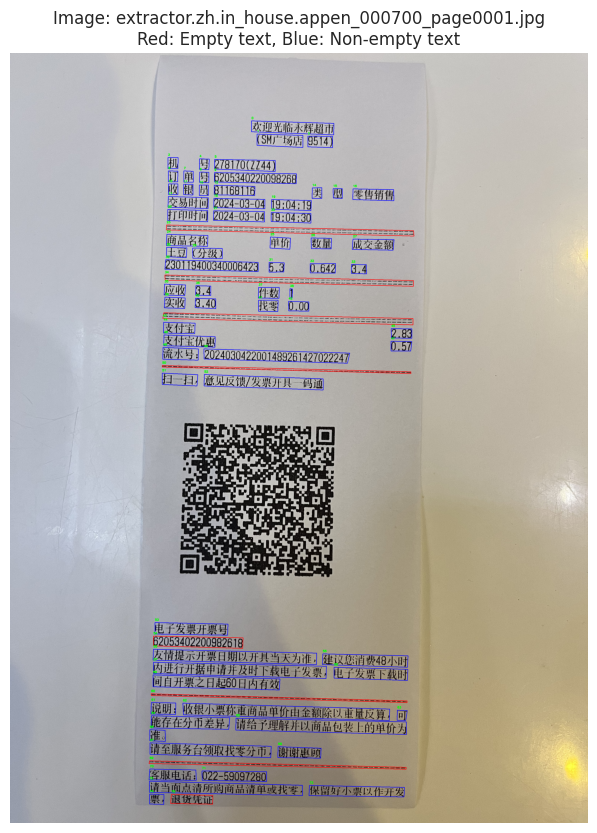


Word Information:
--------------------------------------------------
Word 0:
  Text: '欢迎光临永辉超市'
  Is Empty: False
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 1:
  Text: '(SM广场店'
  Is Empty: False
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 2:
  Text: '9514)'
  Is Empty: False
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 3:
  Text: '机'
  Is Empty: False
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 4:
  Text: '号'
  Is Empty: False
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 5:
  Text: '278170(ZZ44)'
  Is Empty: False
  Language: None
  Orientation: Horizontal
  Tags: ['None']
--------------------------------------------------
Word 6:
 

In [39]:
def visualize_image_with_empty_text(data, image_paths):
    """
    빈 텍스트가 있는 이미지를 선택하여 바운딩 박스와 텍스트 정보를 시각화
    """
    # 빈 텍스트가 있는 이미지 찾기
    valid_img_ids = []
    
    for img_id, img_info in data['images'].items():
        if img_id in image_paths:  # 이미지 파일이 존재하는지 확인
            # 빈 텍스트가 있는 단어가 하나라도 있는지 확인
            has_empty_text = any(
                (word.get('transcription') is not None and word.get('transcription', '').strip() == '')
                for word in img_info['words'].values() 
                if not word.get('illegibility', False)
            )
            if has_empty_text:
                valid_img_ids.append(img_id)
    
    if not valid_img_ids:
        print("No images with empty text found!")
        return
        
    # 랜덤한 이미지 선택
    random_img_id = np.random.choice(valid_img_ids)
    img_info = data['images'][random_img_id]
    
    # 이미지 로드
    img_path = image_paths[random_img_id]
    print(f"Loading image from: {img_path}")
    
    img = cv2.imread(img_path)
    if img is None:
        print(f"Cannot load image: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 이미지 정보 출력
    print("="*50)
    print(f"Image ID: {random_img_id}")
    print(f"Image Path: {img_path}")
    print(f"Image Size: {img_info['img_w']} x {img_info['img_h']}")
    print(f"Image Tags: {img_info.get('tags', ['None'])}")
    print(f"Total Words: {len(img_info['words'])}")
    print("="*50)
    
    # 단어 정보를 저장할 리스트
    word_info_list = []
    
    # 이미지에 모든 바운딩 박스 그리기 (빈 텍스트는 다른 색상으로 표시)
    for word_id, word in img_info['words'].items():
        if not word.get('illegibility', False):
            transcription = word.get('transcription')
            points = np.array(word.get('points', []))
            
            if len(points) > 0:
                # 빈 텍스트인 경우 빨간색, 아닌 경우 파란색으로 표시
                is_empty = transcription is not None and transcription.strip() == ''
                color = (255, 0, 0) if is_empty else (0, 0, 255)  # BGR
                
                # 박스 그리기
                cv2.polylines(img, [points.astype(np.int32)], True, color, 2)
                
                # 텍스트 번호 표시 (박스 왼쪽 상단)
                x, y = points[0]
                cv2.putText(img, str(len(word_info_list)), (int(x), int(y)-10), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                
                # 단어 정보 저장
                word_info = {
                    'index': len(word_info_list),
                    'text': transcription if transcription is not None else 'None',
                    'is_empty': is_empty,
                    'language': word.get('language', 'None'),
                    'orientation': word.get('orientation', 'Horizontal'),
                    'tags': word.get('tags', ['None'])
                }
                word_info_list.append(word_info)
    
    # 이미지 표시
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.title(f'Image: {random_img_id}\nRed: Empty text, Blue: Non-empty text')
    plt.axis('off')
    plt.show()
    
    # 단어 정보 출력
    print("\nWord Information:")
    print("-"*50)
    for word_info in word_info_list:
        print(f"Word {word_info['index']}:")
        print(f"  Text: '{word_info['text']}'")
        print(f"  Is Empty: {word_info['is_empty']}")
        print(f"  Language: {word_info['language']}")
        print(f"  Orientation: {word_info['orientation']}")
        print(f"  Tags: {word_info['tags']}")
        print("-"*50)

# 실행
visualize_image_with_empty_text(data, image_paths)